# Conformalized Early Stopping -- Anomaly Detection

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Some useful functions

In [2]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]


# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                         std = [ 1., 1., 1. ]),
                                   ])

    img = invTrans(img)
    # Convert tensor to numpy array
    npimg = img.cpu().numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    


def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()


In [3]:
import torch as th
import numpy as np

from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt

In [4]:
import sys, os

In [5]:
sys.path.append('../ConformalizedES')
sys.path.append('../third_party/SPADE-pytorch/src/datasets/')

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
from torchvision import transforms
from mvtec import MVTecDataset   # Third party dataloader for the MVTec dataset

In [8]:
# Load the hazelnut dataset
resize = 64      # Resize the image
cropsize = 32    # Apply center crop on the image

train_set = MVTecDataset(root_path='./data', class_name='hazelnut', is_train=True, 
                        resize = resize, cropsize = cropsize)
test_set = MVTecDataset(root_path='./data', class_name='hazelnut', is_train=False, 
                       resize = resize, cropsize = cropsize)
print('Training dataset size is {}, test dataset size is {}'.format(len(train_set), len(test_set)))

Training dataset size is 391, test dataset size is 110


C:\Users\16266\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


## Randomly plot some images

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 2
example_batch_size = 4

n_examples = 100
example_sampler = SubsetRandomSampler(np.arange(n_examples, dtype=np.int64))
example_loader = th.utils.data.DataLoader(test_set, batch_size=example_batch_size,sampler = example_sampler,
                                         num_workers=num_workers)

classes = ['normal', 'defective']

In [10]:
dataiter = iter(example_loader)
images, labels = dataiter.next()   # Returns a list of three tensors, we need the first two: images and labels

    normal  defective  defective  defective


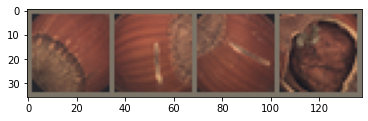

In [11]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(example_batch_size)))

# Train Autoencoder

In [12]:
sys.path.append('../ConformalizedES')
sys.path.append('../third_party')

In [13]:
from method import CES_oneClass
from networks import ConvAutoencoder_32

In [14]:
# Define the model parameters

net = ConvAutoencoder_32()
lr = 0.001
n_epoch = 20
batch_size = 12

In [15]:
import torch.optim as optim

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer = optim.Adam(net.parameters(), lr=lr)

In [16]:
seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

In [17]:
seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

n_training_samples = 291 # Max: 391 - n_val_samples
n_val_samples = 100
n_test_samples = 110 # Max: 110

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

In [18]:
def get_train_loader(batch_size):
    return th.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

train_loader = get_train_loader(batch_size)

# Use larger batch size for validation to speed up computation
val_loader = th.utils.data.DataLoader(train_set, batch_size=n_val_samples, sampler=val_sampler,
                                          num_workers=num_workers)

test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=num_workers)

In [19]:
## seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_oc = CES_oneClass(net, device, train_loader, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader, criterion=criterion,optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 12
n_epochs= 20
learning_rate= 0.001


In [20]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc.full_train(save_dir = './models/oneClass', save_every = save_every)

Epoch 1 of 20, 8% 	 train_loss: 1.44  took: 1.76s
Epoch 1 of 20, 16% 	 train_loss: 1.58  took: 0.48s
Epoch 1 of 20, 24% 	 train_loss: 1.40  took: 0.48s
Epoch 1 of 20, 32% 	 train_loss: 1.39  took: 0.51s
Epoch 1 of 20, 40% 	 train_loss: 1.41  took: 0.53s
Epoch 1 of 20, 48% 	 train_loss: 1.33  took: 0.47s
Epoch 1 of 20, 56% 	 train_loss: 1.49  took: 0.49s
Epoch 1 of 20, 64% 	 train_loss: 1.47  took: 0.51s
Epoch 1 of 20, 72% 	 train_loss: 1.35  took: 0.56s
Epoch 1 of 20, 80% 	 train_loss: 1.28  took: 0.48s
Epoch 1 of 20, 88% 	 train_loss: 1.37  took: 0.51s
Epoch 1 of 20, 96% 	 train_loss: 1.31  took: 0.68s
val_loss = 1.19
Snapshot saved at epoch 1.
Epoch 2 of 20, 8% 	 train_loss: 1.27  took: 1.64s
Epoch 2 of 20, 16% 	 train_loss: 1.29  took: 0.52s
Epoch 2 of 20, 24% 	 train_loss: 1.26  took: 0.49s
Epoch 2 of 20, 32% 	 train_loss: 1.31  took: 0.48s
Epoch 2 of 20, 40% 	 train_loss: 1.21  took: 0.53s
Epoch 2 of 20, 48% 	 train_loss: 1.08  took: 0.50s
Epoch 2 of 20, 56% 	 train_loss: 1.18  to

Epoch 13 of 20, 56% 	 train_loss: 0.60  took: 0.59s
Epoch 13 of 20, 64% 	 train_loss: 0.65  took: 0.70s
Epoch 13 of 20, 72% 	 train_loss: 0.58  took: 0.63s
Epoch 13 of 20, 80% 	 train_loss: 0.57  took: 0.67s
Epoch 13 of 20, 88% 	 train_loss: 0.62  took: 0.66s
Epoch 13 of 20, 96% 	 train_loss: 0.65  took: 0.65s
val_loss = 0.54
Snapshot saved at epoch 13.
Epoch 14 of 20, 8% 	 train_loss: 0.55  took: 2.36s
Epoch 14 of 20, 16% 	 train_loss: 0.67  took: 0.78s
Epoch 14 of 20, 24% 	 train_loss: 0.58  took: 0.59s
Epoch 14 of 20, 32% 	 train_loss: 0.58  took: 0.68s
Epoch 14 of 20, 40% 	 train_loss: 0.63  took: 0.68s
Epoch 14 of 20, 48% 	 train_loss: 0.59  took: 0.68s
Epoch 14 of 20, 56% 	 train_loss: 0.58  took: 0.70s
Epoch 14 of 20, 64% 	 train_loss: 0.60  took: 0.64s
Epoch 14 of 20, 72% 	 train_loss: 0.61  took: 0.66s
Epoch 14 of 20, 80% 	 train_loss: 0.60  took: 0.70s
Epoch 14 of 20, 88% 	 train_loss: 0.68  took: 0.71s
Epoch 14 of 20, 96% 	 train_loss: 0.62  took: 0.73s
val_loss = 0.53
Snaps

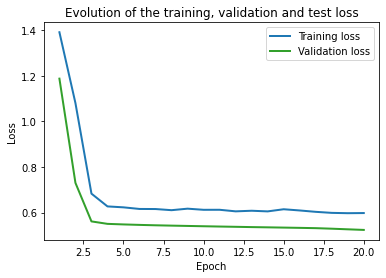

In [26]:
plot_loss(CES_oc.train_loss_history, CES_oc.val_loss_history)

In [36]:
dataiter = iter(train_loader)
images, labels = dataiter.next() 

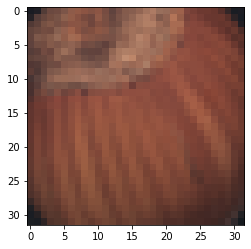

In [37]:
imshow(images[0])

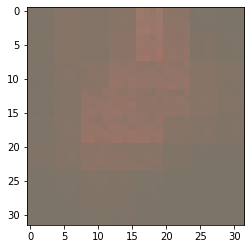

In [38]:
with th.no_grad():
    output = net(images[0][None])

imshow(output[0])

In [25]:
32*32

1024